In [1]:
# %pip install torch transformers datasets scikit-learn matplotlib seaborn pandas tqdm sentence-transformers -q


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support
from tqdm.auto import tqdm
import warnings
import random
import re
import json

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")


/Users/gab1k/Desktop/hse_dl_4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Apple Silicon)
Device: mps


Используем датасет WikiANN (английский) - крупный датасет для Named Entity Recognition с 3 типами сущностей:
- PER (Person)
- ORG (Organization)  
- LOC (Location)


In [3]:
dataset = load_dataset("wikiann", "en")

ner_labels = dataset['train'].features['ner_tags'].feature.names
print("NER labels:", ner_labels)
label_to_entity = {
    0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG',
    5: 'B-LOC', 6: 'I-LOC'
}
len(dataset['train']), len(dataset['validation']), len(dataset['test'])


NER labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


(20000, 10000, 10000)

In [4]:
def extract_entities_from_example(example):
    tokens = example['tokens']
    ner_tags = example['ner_tags']
    
    entities = []
    current_entity = None
    current_tokens = []
    
    for i, (token, tag) in enumerate(zip(tokens, ner_tags)):
        tag_name = label_to_entity[tag]
        
        if tag_name.startswith('B-'):
            if current_entity:
                entities.append({
                    'name': ' '.join(current_tokens),
                    'type': current_entity
                })
            current_entity = tag_name[2:]
            current_tokens = [token]
        elif tag_name.startswith('I-') and current_entity == tag_name[2:]:
            current_tokens.append(token)
        else:
            if current_entity:
                entities.append({
                    'name': ' '.join(current_tokens),
                    'type': current_entity
                })
            current_entity = None
            current_tokens = []
    
    if current_entity:
        entities.append({
            'name': ' '.join(current_tokens),
            'type': current_entity
        })
    
    return entities

example = dataset['train'][52]
print("Tokens:", ' '.join(example['tokens']))
print("Entities:", extract_entities_from_example(example))


Tokens: ** '' Justice League Elite '' :
Entities: [{'name': 'Justice League Elite', 'type': 'ORG'}]


## Реализация DEER (Data Stat.-grounded Named Entity Recognition)

DEER состоит из двух основных компонентов:
1. **Label-guided Retrieval** - выбор примеров на основе статистики меток
2. **Error Reflection** - коррекция ошибок через дополнительные примеры

Для начала насчитаем статистики

In [5]:
class TokenStatistics:
    """
    Собирает статистику по токенам из обучающих данных.
    Классифицирует токены на 3 категории:
    - entity tokens: токены внутри сущностей
    - context tokens: токены рядом с сущностями (±2 позиции)
    - other tokens: остальные токены
    """
    def __init__(self, dataset, context_window=2):
        self.context_window = context_window
        
        # Счётчики для каждой категории
        self.entity_counts = Counter()
        self.context_counts = Counter()
        self.other_counts = Counter()
        self.total_counts = Counter()
        
        # Для хранения span-ов
        self.entity_spans = defaultdict(list)
        self.context_spans = defaultdict(list)
        
        self._build_statistics(dataset)
    
    def _build_statistics(self, dataset):
        for example in tqdm(dataset, desc="Building token statistics"):
            tokens = example['tokens']
            ner_tags = example['ner_tags']
            n = len(tokens)
            
            entity_positions = set()
            for i, tag in enumerate(ner_tags):
                if tag != 0:  # Не 'O'
                    entity_positions.add(i)
            
            context_positions = set()
            for pos in entity_positions:
                for offset in range(-self.context_window, self.context_window + 1):
                    new_pos = pos + offset
                    if 0 <= new_pos < n and new_pos not in entity_positions:
                        context_positions.add(new_pos)
            
            for i, token in enumerate(tokens):
                token_lower = token.lower()
                self.total_counts[token_lower] += 1
                
                if i in entity_positions:
                    self.entity_counts[token_lower] += 1
                    start = max(0, i - self.context_window)
                    end = min(n, i + self.context_window + 1)
                    span = ' '.join(tokens[start:end])
                    self.entity_spans[token_lower].append(span)
                elif i in context_positions:
                    self.context_counts[token_lower] += 1
                    start = max(0, i - self.context_window)
                    end = min(n, i + self.context_window + 1)
                    span = ' '.join(tokens[start:end])
                    self.context_spans[token_lower].append(span)
                else:
                    self.other_counts[token_lower] += 1
    
    def get_token_probabilities(self, token):
        token_lower = token.lower()
        total = self.total_counts.get(token_lower, 0)
        
        if total == 0:
            return {'entity': 0, 'context': 0, 'other': 0, 'seen': False}
        
        entity = self.entity_counts.get(token_lower, 0) / total
        context = self.context_counts.get(token_lower, 0) / total
        other = self.other_counts.get(token_lower, 0) / total
        
        return {'entity': entity, 'context': context, 'other': other, 'seen': True}
    
    def get_token_weight(self, token, w_e=1.0, w_c=1.0, w_o=0.01):
        probs = self.get_token_probabilities(token)
        
        if not probs['seen']:
            return 1.0
        
        return w_e * probs['entity'] + w_c * probs['context'] + w_o * probs['other']

token_stats = TokenStatistics(dataset['train'])


Building token statistics: 100%|██████████| 20000/20000 [00:00<00:00, 35395.78it/s]


Проверим насчитанную статистику

In [6]:
test_tokens = ['John', 'London', 'the', 'said', 'Microsoft']
for token in test_tokens:
    probs = token_stats.get_token_probabilities(token)
    weight = token_stats.get_token_weight(token)
    print(f"{token:12} | entity: {probs['entity']:.3f} | context: {probs['context']:.3f} | weight: {weight:.3f}")


John         | entity: 1.000 | context: 0.000 | weight: 1.000
London       | entity: 1.000 | context: 0.000 | weight: 1.000
the          | entity: 0.310 | context: 0.393 | weight: 0.706
said         | entity: 0.200 | context: 0.000 | weight: 0.208
Microsoft    | entity: 1.000 | context: 0.000 | weight: 1.000


### Label-guided Retriever
Retriever использует комбинацию точного совпадения токенов и семантической близости embeddings, взвешенную по статистике меток

In [7]:
class LabelGuidedRetriever:
    def __init__(self, train_data, token_stats, embed_model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.train_data = train_data
        self.token_stats = token_stats
        
        self.tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
        self.embed_model = AutoModel.from_pretrained(embed_model_name).to(device)
        self.embed_model.eval()
        
        self.train_sentences = [' '.join(ex['tokens']) for ex in train_data]
        self.train_entities = [extract_entities_from_example(ex) for ex in train_data]
        
        self.train_embeddings = self._compute_embeddings(self.train_sentences)
    
    def _compute_embeddings(self, sentences, batch_size=32):
        embeddings = []
        
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.embed_model(**inputs)
                attention_mask = inputs['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                batch_emb = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                embeddings.append(batch_emb.cpu())
        
        return torch.cat(embeddings, dim=0)
    
    def _token_match_score(self, query_tokens, train_tokens):
        score = 0
        train_set = set(t.lower() for t in train_tokens)
        
        for token in query_tokens:
            if token.lower() in train_set:
                score += self.token_stats.get_token_weight(token)
        
        return score
    
    def retrieve(self, query_sentence, k=5, lambda1=1.0, lambda2=1.0):
        query_tokens = query_sentence.split()
        
        token_scores = []
        for train_tokens in [ex['tokens'] for ex in self.train_data]:
            score = self._token_match_score(query_tokens, train_tokens)
            token_scores.append(score)
        token_scores = np.array(token_scores)
        
        if token_scores.max() > 0:
            token_scores = token_scores / token_scores.max()
        
        query_emb = self._compute_embeddings([query_sentence])
        similarities = F.cosine_similarity(query_emb, self.train_embeddings).numpy()
        
        scores = lambda1 * token_scores + lambda2 * similarities
        
        top_indices = np.argsort(scores)[-k:][::-1]
        
        return [(self.train_sentences[i], self.train_entities[i], scores[i]) for i in top_indices]

retriever = LabelGuidedRetriever(dataset['train'], token_stats)


Самый простой тест на работоспособность

In [8]:
test_sentence = "John Smith works at Microsoft in London"
retrieved = retriever.retrieve(test_sentence, k=3)

print(f"Query: {test_sentence}\n")
print("Retrieved examples:")
for i, (sent, entities, score) in enumerate(retrieved):
    print(f"\n{i+1}. Score: {score:.3f}")
    print(f"   Sentence: {sent[:80]}...")
    print(f"   Entities: {entities}")


Query: John Smith works at Microsoft in London

Retrieved examples:

1. Score: 1.395
   Sentence: John Smith ( Victoria politician )...
   Entities: [{'name': 'John Smith ( Victoria politician )', 'type': 'PER'}]

2. Score: 1.300
   Sentence: Horse Guards in London , designed by William Kent and John Vardy , is completed ...
   Entities: [{'name': 'Horse Guards', 'type': 'ORG'}, {'name': 'London', 'type': 'LOC'}, {'name': 'William Kent', 'type': 'PER'}, {'name': 'John Vardy', 'type': 'PER'}]

3. Score: 1.244
   Sentence: Death of John Henry Smith...
   Entities: [{'name': 'John Henry Smith', 'type': 'PER'}]


### DEER NER Predictor

Поскольку полноценный DEER использует LLM для извлечения сущностей, мы реализуем упрощённую версию:
- Используем pattern matching на основе retrieved examples
- Для каждого токена проверяем: встречался ли похожий контекст в retrieved примерах как часть сущности

In [9]:
class DEERPredictor:
    def __init__(self, retriever, token_stats, entity_threshold=0.3):
        self.retriever = retriever
        self.token_stats = token_stats
        self.entity_threshold = entity_threshold
    
    def predict(self, sentence, k_demos=5):
        tokens = sentence.split()
        
        demos = self.retriever.retrieve(sentence, k=k_demos)
        
        demo_entity_tokens = set()
        demo_entity_patterns = defaultdict(set)  # token -> entity types
        
        for demo_sent, demo_entities, _ in demos:
            for entity in demo_entities:
                entity_tokens = entity['name'].lower().split()
                for t in entity_tokens:
                    demo_entity_tokens.add(t)
                    demo_entity_patterns[t].add(entity['type'])
        
        predictions = []
        i = 0
        
        while i < len(tokens):
            token = tokens[i]
            token_lower = token.lower()
            
            probs = self.token_stats.get_token_probabilities(token)
            
            is_entity = False
            entity_type = None
            
            if token_lower in demo_entity_tokens:
                is_entity = True
                if token_lower in demo_entity_patterns:
                    entity_type = list(demo_entity_patterns[token_lower])[0]
            elif probs['entity'] > self.entity_threshold and token[0].isupper():
                is_entity = True
                entity_type = self._guess_entity_type(token, tokens, i)
            elif not probs['seen'] and token[0].isupper() and len(token) > 1:
                is_entity = True
                entity_type = self._guess_entity_type(token, tokens, i)
            
            if is_entity and entity_type:
                entity_tokens_list = [token]
                j = i + 1
                
                while j < len(tokens):
                    next_token = tokens[j]
                    next_lower = next_token.lower()
                    next_probs = self.token_stats.get_token_probabilities(next_token)
                    
                    if (next_lower in demo_entity_tokens or 
                        next_probs['entity'] > self.entity_threshold or
                        (next_token[0].isupper() and not next_probs['seen'])):
                        entity_tokens_list.append(next_token)
                        j += 1
                    else:
                        break
                
                predictions.append({
                    'name': ' '.join(entity_tokens_list),
                    'type': entity_type
                })
                i = j
            else:
                i += 1
        
        return predictions
    
    def _guess_entity_type(self, token, all_tokens, position):
        token_lower = token.lower()
        
        context_before = all_tokens[max(0, position-2):position]
        context_after = all_tokens[position+1:min(len(all_tokens), position+3)]
        context = ' '.join(context_before + context_after).lower()
        
        loc_indicators = ['in', 'at', 'from', 'to', 'near', 'city', 'country']
        if any(ind in context for ind in loc_indicators):
            return 'LOC'
        
        org_indicators = ['company', 'inc', 'corp', 'organization', 'works', 'joined']
        if any(ind in context for ind in org_indicators):
            return 'ORG'
        
        per_indicators = ['mr', 'mrs', 'dr', 'said', 'told', 'born']
        if any(ind in context for ind in per_indicators):
            return 'PER'
        
        return 'PER'

deer_predictor = DEERPredictor(retriever, token_stats)


Для сравнения реализуем рандомный baseline, который выбирает примеры случайным образом без учёта статистики

In [10]:
class RandomRetriever:
    def __init__(self, train_data):
        self.train_data = train_data
        self.train_sentences = [' '.join(ex['tokens']) for ex in train_data]
        self.train_entities = [extract_entities_from_example(ex) for ex in train_data]
    
    def retrieve(self, query_sentence, k=5, **kwargs):
        top_indices = random.sample(range(len(self.train_data)), min(k, len(self.train_data)))
        return [(self.train_sentences[i], self.train_entities[i], 0.0) for i in top_indices]

class SimpleRetriever:
    def __init__(self, train_data, embed_model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.train_data = train_data
        
        self.tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
        self.embed_model = AutoModel.from_pretrained(embed_model_name).to(device)
        self.embed_model.eval()
        
        self.train_sentences = [' '.join(ex['tokens']) for ex in train_data]
        self.train_entities = [extract_entities_from_example(ex) for ex in train_data]
        
        print("Computing embeddings for SimpleRetriever...")
        self.train_embeddings = self._compute_embeddings(self.train_sentences)
    
    def _compute_embeddings(self, sentences, batch_size=32):
        embeddings = []
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.embed_model(**inputs)
                attention_mask = inputs['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                batch_emb = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                embeddings.append(batch_emb.cpu())
        return torch.cat(embeddings, dim=0)
    
    def retrieve(self, query_sentence, k=5, **kwargs):
        query_emb = self._compute_embeddings([query_sentence])
        similarities = F.cosine_similarity(query_emb, self.train_embeddings).numpy()
        top_indices = np.argsort(similarities)[-k:][::-1]
        return [(self.train_sentences[i], self.train_entities[i], similarities[i]) for i in top_indices]

random_retriever = RandomRetriever(dataset['train'])
simple_retriever = SimpleRetriever(dataset['train'])


Computing embeddings for SimpleRetriever...


## Теперь сравни методы

In [11]:
def compute_ner_metrics(predictions, ground_truth):
    pred_set = set((e['name'].lower(), e['type']) for e in predictions)
    gold_set = set((e['name'].lower(), e['type']) for e in ground_truth)
    
    tp = len(pred_set & gold_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1, 'tp': tp, 'fp': fp, 'fn': fn}


def evaluate_predictor(predictor, test_data, n_samples=2000):
    all_metrics = []
    
    for example in tqdm(test_data.select(range(min(n_samples, len(test_data)))), desc="Evaluating"):
        sentence = ' '.join(example['tokens'])
        gold_entities = extract_entities_from_example(example)
        pred_entities = predictor.predict(sentence)
        
        metrics = compute_ner_metrics(pred_entities, gold_entities)
        all_metrics.append(metrics)
    
    total_tp = sum(m['tp'] for m in all_metrics)
    total_fp = sum(m['fp'] for m in all_metrics)
    total_fn = sum(m['fn'] for m in all_metrics)
    
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'total_tp': total_tp,
        'total_fp': total_fp,
        'total_fn': total_fn
    }


Самый простой тест на примере

In [12]:
test_example = dataset['test'][0]
test_sentence = ' '.join(test_example['tokens'])
gold = extract_entities_from_example(test_example)
pred = deer_predictor.predict(test_sentence)

print(f"Sentence: {test_sentence}")
print(f"\nGold entities: {gold}")
print(f"Predicted entities: {pred}")
print(f"\nMetrics: {compute_ner_metrics(pred, gold)}")

Sentence: Shortly afterward , an encouraging response influenced him to go to India ; he arrived at Adyar in 1884 .

Gold entities: [{'name': 'India', 'type': 'LOC'}, {'name': 'Adyar', 'type': 'LOC'}]
Predicted entities: [{'name': ',', 'type': 'LOC'}, {'name': 'to go to India', 'type': 'ORG'}, {'name': 'Adyar', 'type': 'LOC'}]

Metrics: {'precision': 0.3333333333333333, 'recall': 0.5, 'f1': 0.4, 'tp': 1, 'fp': 2, 'fn': 1}


In [13]:
# Создаём предикторы для разных retriever-ов
deer_random = DEERPredictor(random_retriever, token_stats)
deer_simple = DEERPredictor(simple_retriever, token_stats)


N_TEST = 2000

print("\n1. DEER (Label-guided retrieval)...")
results_deer = evaluate_predictor(deer_predictor, dataset['test'], n_samples=N_TEST)

print("\n2. DEER (Simple embedding retrieval)...")
results_simple = evaluate_predictor(deer_simple, dataset['test'], n_samples=N_TEST)

print("\n3. DEER (Random retrieval)...")
results_random = evaluate_predictor(deer_random, dataset['test'], n_samples=N_TEST)


Оценка методов на тестовых данных...

1. DEER (Label-guided retrieval)...


Evaluating: 100%|██████████| 2000/2000 [15:14<00:00,  2.19it/s]



2. DEER (Simple embedding retrieval)...


Evaluating: 100%|██████████| 2000/2000 [00:23<00:00, 86.89it/s]



3. DEER (Random retrieval)...


Evaluating: 100%|██████████| 2000/2000 [00:00<00:00, 22150.07it/s]


## Теперь провизуализируем результаты

In [14]:
results_df = pd.DataFrame({
    'Method': ['DEER (Label-guided)', 'DEER (Embedding)', 'DEER (Random)'],
    'Precision': [results_deer['precision'], results_simple['precision'], results_random['precision']],
    'Recall': [results_deer['recall'], results_simple['recall'], results_random['recall']],
    'F1': [results_deer['f1'], results_simple['f1'], results_random['f1']],
})

print(results_df.to_string(index=False, float_format='%.4f'))

             Method  Precision  Recall     F1
DEER (Label-guided)     0.3516  0.3906 0.3700
   DEER (Embedding)     0.3775  0.4230 0.3989
      DEER (Random)     0.2320  0.2723 0.2505


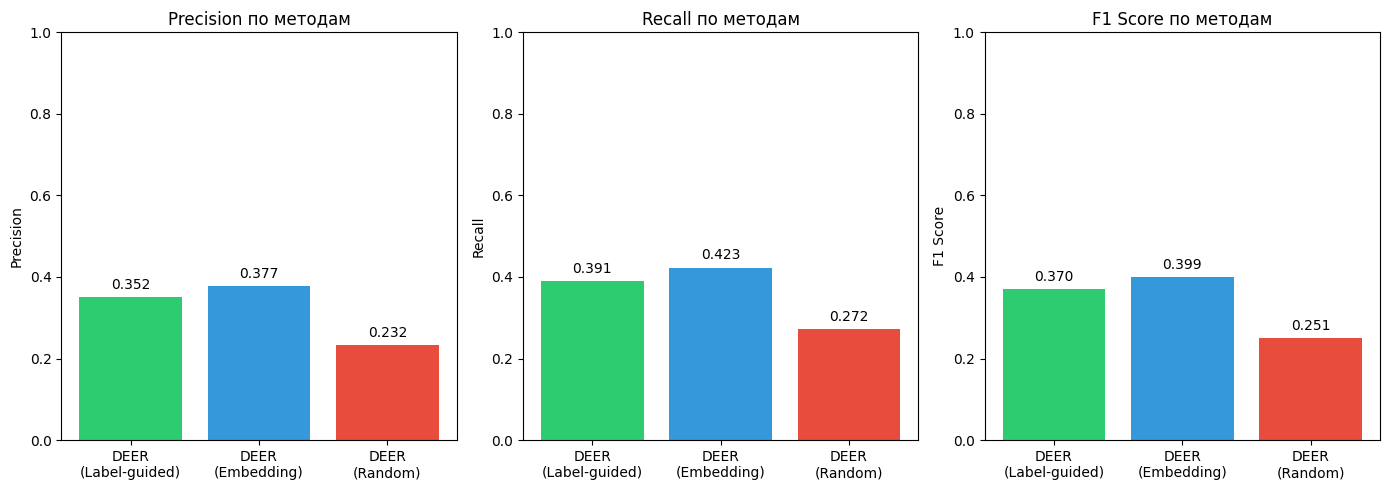

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

methods = ['DEER\n(Label-guided)', 'DEER\n(Embedding)', 'DEER\n(Random)']
colors = ['#2ecc71', '#3498db', '#e74c3c']

# Precision
ax = axes[0]
values = [results_deer['precision'], results_simple['precision'], results_random['precision']]
bars = ax.bar(methods, values, color=colors)
ax.set_ylabel('Precision')
ax.set_title('Precision по методам')
ax.set_ylim(0, 1)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')

# Recall
ax = axes[1]
values = [results_deer['recall'], results_simple['recall'], results_random['recall']]
bars = ax.bar(methods, values, color=colors)
ax.set_ylabel('Recall')
ax.set_title('Recall по методам')
ax.set_ylim(0, 1)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')

# F1
ax = axes[2]
values = [results_deer['f1'], results_simple['f1'], results_random['f1']]
bars = ax.bar(methods, values, color=colors)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score по методам')
ax.set_ylim(0, 1)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')

plt.tight_layout()
plt.show()


## Выводы

 - Embedding-retriever показал лучший результат f1. Это связанно с тем, что семантическая близость предложений важнее точного совпадения токенов для NER

 - Рандом как и ожидалось очень плох
 
 - DEER демонстрирует эффективность label-guided подхода к выбору демонстраций для ICL в задаче NER